In [1]:
import torch
import torch.nn as nn
import torchvision as tv
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
import seaborn as sns
from matplotlib.axes._subplots import Axes
from sklearn.metrics import confusion_matrix
import pandas as pd
import pendulum
from tqdm import tqdm

# Model

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.losses = {}
        self.accuracys = {}
        self.iterations = 0
        
        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out
    
    def fit(self, optimizer, error, train_loader):
        for images, labels in tqdm(train_loader):
            self.iterations += 1

            images, labels = images.to(device), labels.to(device)
            train = Variable(images.view(*images.shape))
            #train = Variable(images)
            labels = Variable(labels)

            outputs = self.forward(train)
            loss = error(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            self.loss = loss
            self.losses[self.iterations] = loss.data

    
    def validate(self, val_loader):
        test_list = []
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                val = Variable(images.view(*images.shape))
                outputs = self.forward(val)
            
                predictions = torch.max(outputs, 1)[1].to(device)

                test_list.append({
                    'y_pred': predictions,
                    'y_true': labels,
                    'correct': (predictions == labels).sum(),
                    'length': len(labels)
                })
        
        correct = sum([t['correct'] for t in test_list])
        total = sum([t['length'] for t in test_list])
        accuracy = correct * 100 / total

        self.accuracys[self.iterations] = accuracy

        return accuracy, test_list

# Functions

In [3]:
class_name = lambda cls: str(cls).split("<class '")[1].split("'>")[0].split(".")[-1]


def load_data(batch_size=100, train_size=50000, val_size=10000):
    dataset = tv.datasets.FashionMNIST(
        root='./data',
        train=True,
        transform=tv.transforms.ToTensor(),
        download=True
    )

    test_set = tv.datasets.FashionMNIST(
        root = './data',
        train = False,
        transform = tv.transforms.ToTensor(),
        download = True
    )

    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Data loader
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, 
        batch_size=batch_size, 
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, 
        batch_size=batch_size, 
        shuffle=False
    )

    return {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader,
        'dataset': dataset
    }


def image_dataset_merge(rows, cols, dataset):
    subset = torch.utils.data.Subset(dataset, np.arange(rows*cols))

    row_images = []
    for i in range(rows):
        row = torch.utils.data.Subset(subset, np.arange(i*cols, (i*cols) + cols))
        images = [a[0][0].numpy() for a in row]
        row_images.append(np.concatenate(images, axis=1))

    tot_image = np.concatenate(row_images)

    return tot_image


def filter_dataset(dataset, func):
    target_indices = np.arange(len(dataset.targets))
    mask = func(dataset.targets).numpy()
    mask_idx = target_indices[mask]
    subset = torch.utils.data.Subset(dataset, mask_idx)
    return subset


def train_and_save(train_loader, val_loader, load_model=False, model_path='./data/model.pth', opt=Adam, er=nn.CrossEntropyLoss, learning_rate=0.001, num_epochs=10):
    if load_model:
        model = torch.load(model_path)
    else:
        model = CNN()

    model.to(device)

    optimizer=opt(model.parameters(), lr=learning_rate)
    error = er()

    for i in range(num_epochs):
        model.fit(optimizer, error, train_loader)
        model.validate(val_loader)
        print(f"Epoch[{i+1}/{num_epochs}]: Iteration: {model.iterations}, Loss: {model.losses[model.iterations]}, Accuracy: {model.accuracys[model.iterations]}")


    torch.save(model, model_path)

    losses = model.losses.copy()
    losses = [(k, v) for k, v in losses.items() if k in [a for a in model.accuracys]]
    sorted_losses = sorted(losses, key=lambda x: x[1])

    best = {
        'optimizer': class_name(opt),
        'error': class_name(er),
        'loss': sorted_losses[0][1],
        'iteration': sorted_losses[0][0],
        'accuracy': model.accuracys[sorted_losses[0][0]],
        'learning_rate': learning_rate
    }
    return model, best

# Checking if gpu is available

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'Graphics card: {torch.cuda.get_device_name(0)}')

print(f'Device that is currently assigned is: {device}')

Graphics card: NVIDIA GeForce RTX 3060 Ti
Device that is currently assigned is: cuda


# Data loading

In [5]:
# Fashion MNIST dataset 
batch_size=100
train_size=50000
val_size=10000

data_dict = load_data(batch_size=batch_size, train_size=train_size, val_size=val_size)
train_loader = data_dict['train']
val_loader = data_dict['val']
test_loader = data_dict['test']
dataset = data_dict['dataset']
print(dataset)
print(f'The dataset FashionMNIST have 60000 datapoints.')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
The dataset FashionMNIST have 60000 datapoints.


### Visualizing dataset grouped by class

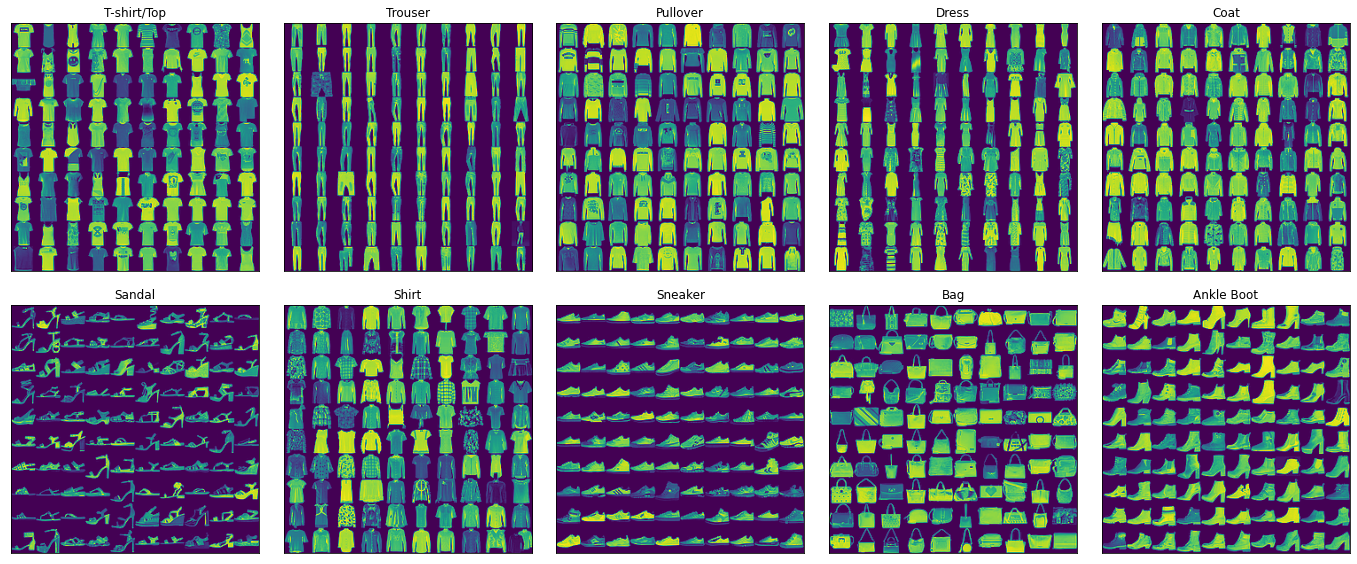

In [87]:
label_map = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

rows = 2
cols = 5
#Create on big plot containing subplots
figure, axis = plt.subplots(rows, cols, figsize=(24,10))

row = 0
for label in range(10):
    col = label % cols
    increment = 1 if label != 0 and col == 0 else 0
    row += increment

    subset = filter_dataset(dataset, lambda target: target == label)
    img = image_dataset_merge(10, 10, subset)

    # Put image in subplot
    sub_plot = axis[row, col]
    sub_plot.set_xticks([])
    sub_plot.set_yticks([])
    sub_plot.imshow(img)
    sub_plot.set_title(label_map[label])

# Adjust spacing
plt.subplots_adjust(
    wspace=0.1, 
    hspace=0.08
)
plt.show()

# Optimizers

In [7]:
#Init list for best losses for each configuration.
best_losses = []

## Adam

In [8]:
learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training Model with Adam Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with Adam Optimizer of learning rate: 0.0001


100%|██████████| 100/100 [00:00<00:00, 106.84it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.3937217593193054, Accuracy: 87.3499984741211


100%|██████████| 100/100 [00:00<00:00, 105.94it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.3307754397392273, Accuracy: 88.23999786376953


100%|██████████| 100/100 [00:00<00:00, 105.82it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.22851134836673737, Accuracy: 88.81999969482422


100%|██████████| 100/100 [00:00<00:00, 104.86it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.1519256830215454, Accuracy: 89.87999725341797


100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.2082224041223526, Accuracy: 90.16999816894531


100%|██████████| 100/100 [00:00<00:00, 106.38it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.2994009256362915, Accuracy: 90.19999694824219


100%|██████████| 100/100 [00:00<00:00, 106.95it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.17230340838432312, Accuracy: 89.88999938964844


100%|██████████| 100/100 [00:00<00:00, 106.84it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.3019256889820099, Accuracy: 90.58999633789062


100%|██████████| 100/100 [00:00<00:00, 106.04it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.2585906684398651, Accuracy: 90.02999877929688


100%|██████████| 100/100 [00:00<00:00, 106.84it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.31620675325393677, Accuracy: 90.43000030517578
------------------------------------------------------------------------------------------------------------------------
Training Model with Adam Optimizer of learning rate: 0.001


100%|██████████| 100/100 [00:00<00:00, 104.60it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.4520845413208008, Accuracy: 86.68999481201172


100%|██████████| 100/100 [00:00<00:00, 105.60it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.19550396502017975, Accuracy: 87.95999908447266


100%|██████████| 100/100 [00:00<00:00, 104.49it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.3519323766231537, Accuracy: 89.54000091552734


100%|██████████| 100/100 [00:00<00:00, 105.15it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.27720212936401367, Accuracy: 89.11000061035156


100%|██████████| 100/100 [00:00<00:00, 105.37it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.24395988881587982, Accuracy: 90.3699951171875


100%|██████████| 100/100 [00:00<00:00, 105.82it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.14249739050865173, Accuracy: 90.79999542236328


100%|██████████| 100/100 [00:00<00:00, 105.83it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.16577208042144775, Accuracy: 90.54000091552734


100%|██████████| 100/100 [00:00<00:00, 105.93it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.1053420901298523, Accuracy: 90.90999603271484


100%|██████████| 100/100 [00:00<00:00, 105.27it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.2634563744068146, Accuracy: 90.94999694824219


100%|██████████| 100/100 [00:00<00:00, 105.04it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.14328235387802124, Accuracy: 90.75
------------------------------------------------------------------------------------------------------------------------
Training Model with Adam Optimizer of learning rate: 0.01


100%|██████████| 100/100 [00:00<00:00, 105.15it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.44473037123680115, Accuracy: 87.04999542236328


100%|██████████| 100/100 [00:00<00:00, 105.05it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.3084086775779724, Accuracy: 86.37999725341797


100%|██████████| 100/100 [00:00<00:00, 105.37it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.21834558248519897, Accuracy: 89.98999786376953


100%|██████████| 100/100 [00:00<00:00, 105.93it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.24055679142475128, Accuracy: 89.36000061035156


100%|██████████| 100/100 [00:00<00:00, 104.94it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.3163951635360718, Accuracy: 87.65999603271484


100%|██████████| 100/100 [00:00<00:00, 104.61it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.30933678150177, Accuracy: 90.63999938964844


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.2643481194972992, Accuracy: 89.87999725341797


100%|██████████| 100/100 [00:00<00:00, 103.95it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.36066487431526184, Accuracy: 89.93999481201172


100%|██████████| 100/100 [00:00<00:00, 105.16it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.28589269518852234, Accuracy: 89.9000015258789


100%|██████████| 100/100 [00:00<00:00, 106.04it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.17164230346679688, Accuracy: 89.22999572753906
------------------------------------------------------------------------------------------------------------------------


## SGD

In [9]:
learning_rates = [0.0001, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training Model with SGD Optimizer of learning rate: {lr}')
    model, best = train_and_save(train_loader, val_loader, opt=SGD, load_model=False, num_epochs=10, learning_rate=lr)
    best_losses.append(best)
    print('-' * 120)

Training Model with SGD Optimizer of learning rate: 0.0001


100%|██████████| 100/100 [00:00<00:00, 102.99it/s]


Epoch[1/10]: Iteration: 500, Loss: 1.7835257053375244, Accuracy: 56.38999938964844


100%|██████████| 100/100 [00:00<00:00, 104.49it/s]


Epoch[2/10]: Iteration: 1000, Loss: 1.4015752077102661, Accuracy: 64.97000122070312


100%|██████████| 100/100 [00:00<00:00, 104.94it/s]


Epoch[3/10]: Iteration: 1500, Loss: 1.2229483127593994, Accuracy: 69.40999603271484


100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Epoch[4/10]: Iteration: 2000, Loss: 1.1297615766525269, Accuracy: 71.4000015258789


100%|██████████| 100/100 [00:00<00:00, 104.39it/s]


Epoch[5/10]: Iteration: 2500, Loss: 1.0516345500946045, Accuracy: 72.47000122070312


100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.9567204117774963, Accuracy: 73.22000122070312


100%|██████████| 100/100 [00:00<00:00, 104.28it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.8871095776557922, Accuracy: 74.6199951171875


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.8448037505149841, Accuracy: 74.95999908447266


100%|██████████| 100/100 [00:00<00:00, 105.82it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.765333354473114, Accuracy: 75.45999908447266


100%|██████████| 100/100 [00:00<00:00, 104.49it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.7846372127532959, Accuracy: 75.55999755859375
------------------------------------------------------------------------------------------------------------------------
Training Model with SGD Optimizer of learning rate: 0.001


100%|██████████| 100/100 [00:00<00:00, 106.49it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.753573477268219, Accuracy: 76.5


100%|██████████| 100/100 [00:00<00:00, 105.26it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.5513893365859985, Accuracy: 79.1199951171875


100%|██████████| 100/100 [00:01<00:00, 98.14it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.49946829676628113, Accuracy: 81.41999816894531


100%|██████████| 100/100 [00:00<00:00, 105.05it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.5688122510910034, Accuracy: 82.33999633789062


100%|██████████| 100/100 [00:00<00:00, 105.05it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.4251355826854706, Accuracy: 83.38999938964844


100%|██████████| 100/100 [00:00<00:00, 105.26it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.44785255193710327, Accuracy: 84.43000030517578


100%|██████████| 100/100 [00:00<00:00, 105.37it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.4166312515735626, Accuracy: 84.65999603271484


100%|██████████| 100/100 [00:00<00:00, 104.38it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.34441059827804565, Accuracy: 85.05999755859375


100%|██████████| 100/100 [00:00<00:00, 105.26it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.5823423862457275, Accuracy: 85.79000091552734


100%|██████████| 100/100 [00:01<00:00, 97.66it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.3603794574737549, Accuracy: 85.80999755859375
------------------------------------------------------------------------------------------------------------------------
Training Model with SGD Optimizer of learning rate: 0.01


100%|██████████| 100/100 [00:00<00:00, 104.83it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.5104336738586426, Accuracy: 85.07999420166016


100%|██████████| 100/100 [00:00<00:00, 104.93it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.44307079911231995, Accuracy: 86.79000091552734


100%|██████████| 100/100 [00:00<00:00, 105.15it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.3064417243003845, Accuracy: 88.47000122070312


100%|██████████| 100/100 [00:00<00:00, 104.60it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.4604913592338562, Accuracy: 88.87999725341797


100%|██████████| 100/100 [00:00<00:00, 104.93it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.22726577520370483, Accuracy: 88.19999694824219


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.2642190158367157, Accuracy: 88.75999450683594


100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.18215183913707733, Accuracy: 90.0999984741211


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.2993607223033905, Accuracy: 89.91999816894531


100%|██████████| 100/100 [00:00<00:00, 105.15it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.22215783596038818, Accuracy: 89.54000091552734


100%|██████████| 100/100 [00:00<00:00, 105.04it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.23254989087581635, Accuracy: 89.88999938964844
------------------------------------------------------------------------------------------------------------------------


Decide what lossfunction is best for classification

In [10]:
sorted_losses = sorted(best_losses, key=lambda x: x['loss'])
best_loss = sorted_losses[0]
print("Configuration for lowest loss:")
print("-" * 120)
for k, v in best_loss.items():
    print(f'{k}: {v}')
print("-" * 120)
print(f'Best Optimizer is {best_loss["optimizer"]} with the learning rate of {best_loss["learning_rate"]}')

Configuration for lowest loss:
------------------------------------------------------------------------------------------------------------------------
optimizer: Adam
error: CrossEntropyLoss
loss: 0.1053420901298523
iteration: 4000
accuracy: 90.90999603271484
learning_rate: 0.001
------------------------------------------------------------------------------------------------------------------------
Best Optimizer is Adam with the learning rate of 0.001


# Training

In [11]:
model, best = train_and_save(train_loader, val_loader, opt=Adam, load_model=False, model_path='./data/adam-lr-0001.pth',num_epochs=10, learning_rate=best_loss['learning_rate'])

100%|██████████| 100/100 [00:00<00:00, 104.28it/s]


Epoch[1/10]: Iteration: 500, Loss: 0.4489428997039795, Accuracy: 88.86000061035156


100%|██████████| 100/100 [00:00<00:00, 105.93it/s]


Epoch[2/10]: Iteration: 1000, Loss: 0.30733737349510193, Accuracy: 87.94999694824219


100%|██████████| 100/100 [00:00<00:00, 105.37it/s]


Epoch[3/10]: Iteration: 1500, Loss: 0.2711549997329712, Accuracy: 90.5999984741211


100%|██████████| 100/100 [00:00<00:00, 105.60it/s]


Epoch[4/10]: Iteration: 2000, Loss: 0.08185110986232758, Accuracy: 89.88999938964844


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[5/10]: Iteration: 2500, Loss: 0.167116180062294, Accuracy: 91.12999725341797


100%|██████████| 100/100 [00:01<00:00, 98.14it/s]


Epoch[6/10]: Iteration: 3000, Loss: 0.16313457489013672, Accuracy: 91.58999633789062


100%|██████████| 100/100 [00:00<00:00, 104.49it/s]


Epoch[7/10]: Iteration: 3500, Loss: 0.24114665389060974, Accuracy: 90.81999969482422


100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Epoch[8/10]: Iteration: 4000, Loss: 0.1636926680803299, Accuracy: 91.37999725341797


100%|██████████| 100/100 [00:00<00:00, 105.05it/s]


Epoch[9/10]: Iteration: 4500, Loss: 0.283257395029068, Accuracy: 90.93999481201172


100%|██████████| 100/100 [00:00<00:00, 104.38it/s]


Epoch[10/10]: Iteration: 5000, Loss: 0.15883836150169373, Accuracy: 91.45999908447266


## Iterations vs Loss

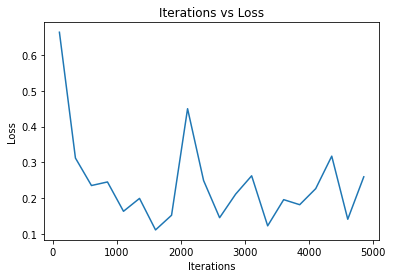

In [12]:
sorted_losses = sorted(model.losses.items(), key=lambda x: x[0])
iterations, losses = zip(*sorted_losses)
iterations = iterations[100:]
np_losses = [loss.cpu().numpy() for loss in losses][100:]

iterations = [n for i, n in enumerate(iterations) if i % 250 == 0]
np_losses = [n for i, n in enumerate(np_losses) if i % 250 == 0]

plt.plot(iterations, np_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

## Iterations Vs Accuracy

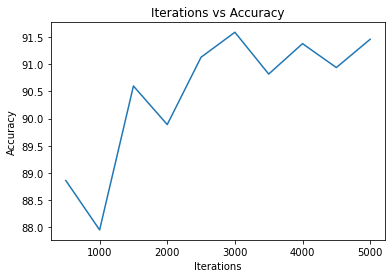

In [13]:
sorted_accuracys = sorted(model.accuracys.items(), key=lambda x: x[0])
iterations, accuracys = zip(*sorted_accuracys)
np_accuracys = [a.cpu().numpy() for a in accuracys]
plt.plot(iterations, np_accuracys)

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

## Confusion Matrix

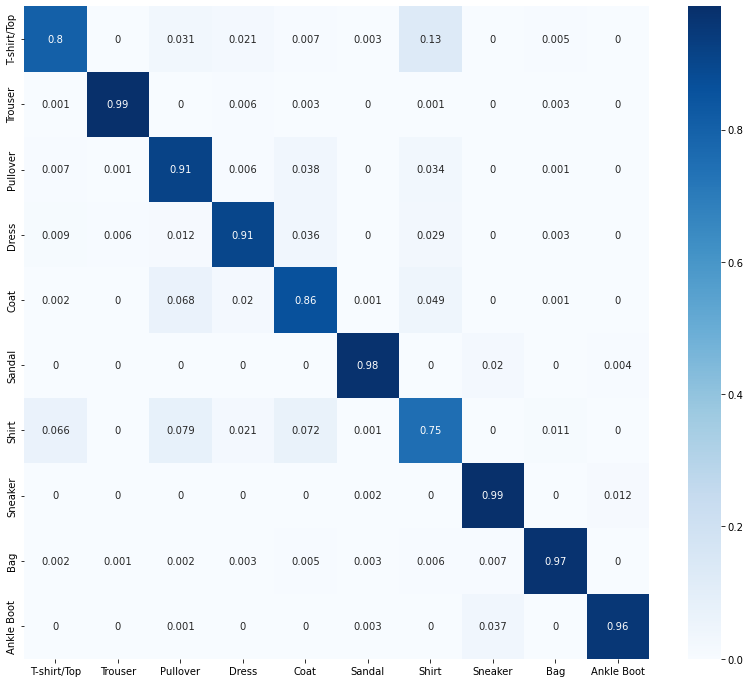

In [14]:
model = torch.load('./data/adam-lr-0001.pth')
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        x = Variable(images.view(*images.shape))
        outputs = model(x)
        predictions = torch.max(outputs, 1)[1].to(device)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)

# Normalize for percentages
cf_matrix_normalized = (cf_matrix / np.sum(cf_matrix)) * 10

# DF for better labeling
df_cf_matrix = pd.DataFrame(
    cf_matrix_normalized, 
    index=[label_map[i] for i in range(10)], 
    columns=[label_map[i] for i in range(10)]
)

plt.figure(figsize=(14, 12))
sns.heatmap(df_cf_matrix, annot=True, cmap=plt.cm.Blues)
plt.show()


# Check how batch_size increases training duration

In [15]:
batch_sizes = [2, 4, 8, 16, 32]
diffs = []

for batch_size in batch_sizes:
    data_dict = load_data(batch_size=batch_size, train_size=50000, val_size=10000)
    temp_train_loader = data_dict['train']
    temp_val_loader =  data_dict['val']
    start = pendulum.now()
    train_and_save(temp_train_loader, temp_val_loader, num_epochs=1)
    diff = pendulum.now() - start
    diffs.append(diff)
    print('-' * 120)
    print(f'A run with batch_size {batch_size} took: {diff.as_interval()}.')
    print('-' * 120)

100%|██████████| 5000/5000 [00:05<00:00, 902.53it/s]


Epoch[1/1]: Iteration: 25000, Loss: 1.714870810508728, Accuracy: 87.0999984741211
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 2 took: 1 minute 17 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 2500/2500 [00:03<00:00, 768.53it/s]


Epoch[1/1]: Iteration: 12500, Loss: 0.2882196009159088, Accuracy: 86.88999938964844
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 4 took: 42 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 1250/1250 [00:02<00:00, 603.61it/s]


Epoch[1/1]: Iteration: 6250, Loss: 0.5047585368156433, Accuracy: 88.36000061035156
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 8 took: 24 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 625/625 [00:01<00:00, 436.45it/s]


Epoch[1/1]: Iteration: 3125, Loss: 0.24664311110973358, Accuracy: 88.75999450683594
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 16 took: 14 seconds.
------------------------------------------------------------------------------------------------------------------------


100%|██████████| 313/313 [00:01<00:00, 252.63it/s]


Epoch[1/1]: Iteration: 1563, Loss: 0.25648775696754456, Accuracy: 82.5999984741211
------------------------------------------------------------------------------------------------------------------------
A run with batch_size 32 took: 10 seconds.
------------------------------------------------------------------------------------------------------------------------


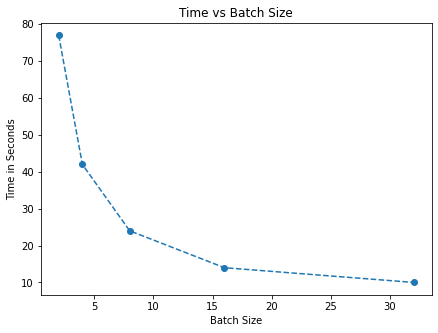

In [16]:
plt.figure(figsize=(7, 5))
plt.title('Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Time in Seconds')
plt.plot(batch_sizes, [d.in_seconds() for d in diffs], linestyle='--', marker='o')
plt.show()

We can clearly see that the time taken vs batch_size is not linear.